In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 46.1 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import torch
import transformers as ppb
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import numpy as np
import pandas as pd
import re

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, SimpleRNN,LSTM, Activation
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train = pd.read_csv(f"/content/drive/MyDrive/CS3244/Final/Updated/full_train_preprocessed_subset.csv",
                 lineterminator='\n')
test = pd.read_csv(f"/content/drive/MyDrive/CS3244/Final/Updated/full_test_preprocessed_subset.csv",
                 lineterminator='\n')
validate = pd.read_csv(f"/content/drive/MyDrive/CS3244/Final/Updated/full_val_preprocessed_subset.csv",
                 lineterminator='\n')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train['text']


0                           Nobody go to Walmart in sulphur
1          @emberlhamon @MLidak welcome to the ugly club!! 
2                             getting to help coach jr high
3         Yo Gotti and Black Youngsta on stage we all th...
4         @spenceribarra just making sure I haven't been...
                                ...                        
133994    Agape Worshippers  their voices are so angelic...
133995                               @abike \nHe's a cutie 
133996                               @Americooligan thanks 
133997                           Ari's mom braided my hair 
133998                                    RT @shwetavyas007
Name: text, Length: 133999, dtype: object

In [ ]:
def process(sen):
  if ":" in sen:
    sentence =sen[sen.index(":")+1:]
    return sentence
  return sen

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

#Pre-processing
#train["tweets"] = train["tweets"].apply(process)
#train["tweets"] = test["tweets"].apply(process)

train["text"] = train["text"].apply(preprocess_text)
test["text"] = test["text"].apply(preprocess_text)
validate['text'] = validate['text'].apply(preprocess_text)

X_train = train['text']
Y_train = train['label']

X_test = test['text']
Y_test = test['label']

X_valid = validate['text']
Y_valid = validate['label']

In [ ]:
X_train.values

array(['Nobody go to Walmart in sulphur',
       ' emberlhamon MLidak welcome to the ugly club ',
       'getting to help coach jr high', ..., ' Americooligan thanks ',
       'Ari s mom braided my hair ', 'RT shwetavyas '], dtype=object)

In [ ]:
possible_labels = train.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{2: 0, 4: 1, 0: 2, 1: 3, 3: 4}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_valid.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    X_test.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(Y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(Y_valid.values)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(Y_test.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
len(dataset_train), len(dataset_val), len(dataset_test)

(133999, 17223, 17063)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
print(len(dataloader_train))

44667


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],}       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f"/content/drive/MyDrive/CS3244/DistilBert/finetuned_BERT_epoch_{epoch}.model")
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    #accuracy_per_class(predictions, true_vals)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/44667 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2984542881002699
Validation loss: 1.2416411212340006
F1 Score (Weighted): 0.47037985431024804


Epoch 2:   0%|          | 0/44667 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1384472482291395
Validation loss: 1.2662855819749528
F1 Score (Weighted): 0.48085540438960367


Epoch 3:   0%|          | 0/44667 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9807017568295268
Validation loss: 1.4490703670106027
F1 Score (Weighted): 0.47743612733795504


Epoch 4:   0%|          | 0/44667 [00:00<?, ?it/s]

In [ ]:
state = torch.load(f"/content/drive/MyDrive/CS3244/DistilBert/finetuned_BERT_epoch_2.model", map_location='cpu')
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
def predict(model,test_dataloader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    preds = []
    
    with torch.no_grad():  

      for batch in test_dataloader:
          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          #print(b_input_ids)
          #print(b_input_mask)
                
          outputs = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask)
          logits = outputs.logits

          logits = logits.detach().cpu().numpy()
          for logit in logits:
              preds.append(logit)

    return preds

In [ ]:
result_1 = predict(model,dataloader_test)
from scipy.special import softmax

pred_labels_test = np.argmax(result_1, axis = 1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(Y_test,pred_labels_test))
print(classification_report(Y_test,pred_labels_test))


0.48291625153841644
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      3934
           1       0.39      0.44      0.41      3546
           2       0.39      0.34      0.36      2911
           3       0.56      0.53      0.54      3619
           4       0.46      0.43      0.45      3053

    accuracy                           0.48     17063
   macro avg       0.48      0.47      0.47     17063
weighted avg       0.48      0.48      0.48     17063



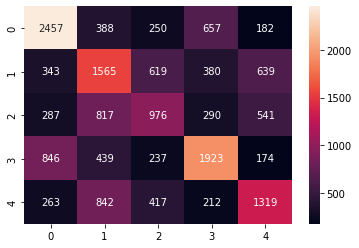

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cf_matrix = confusion_matrix(Y_test,pred_labels_test)  
sb.heatmap(cf_matrix, annot=True, fmt='g')